In [ ]:
%pip install opencv-python-headless numpy matplotlib easy-mhi dlib


# Code to generate OFI images for model input

## Visualizing output of a sample video

Error: Could not read frame 140


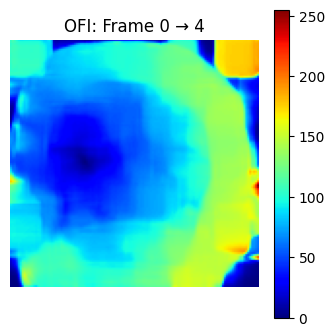

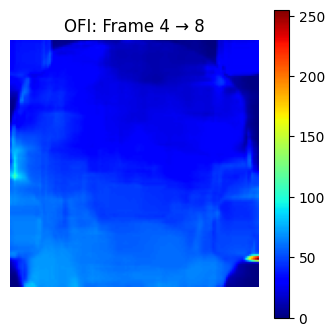

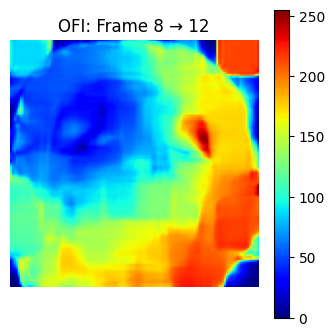

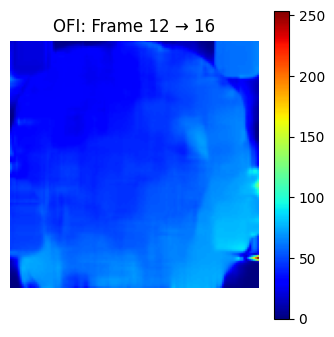

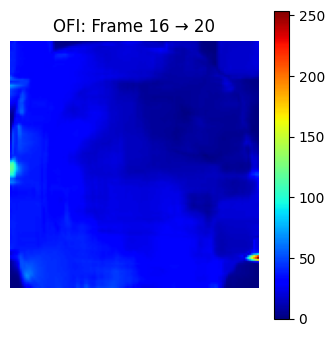

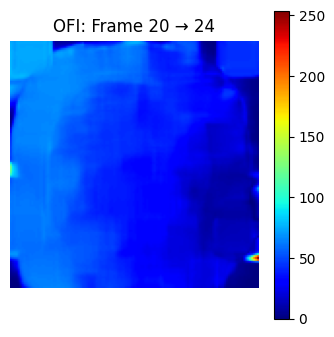

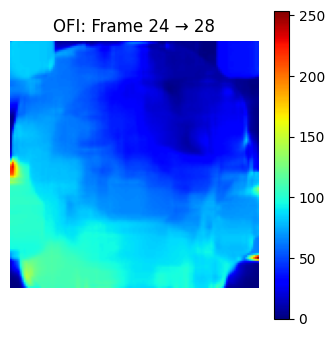

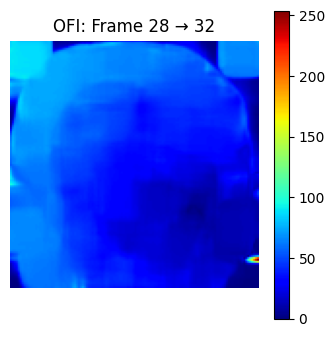

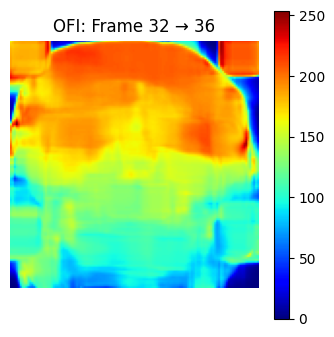

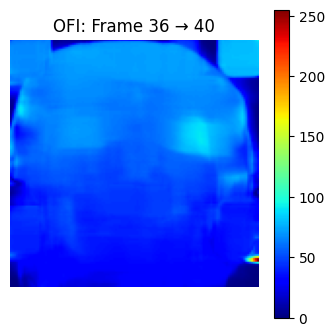

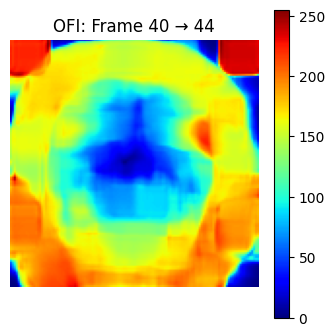

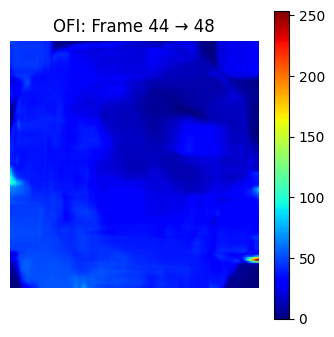

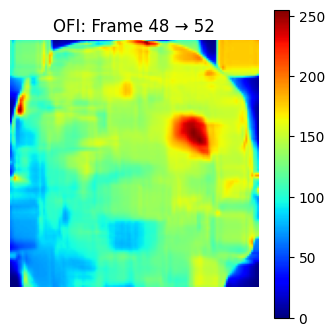

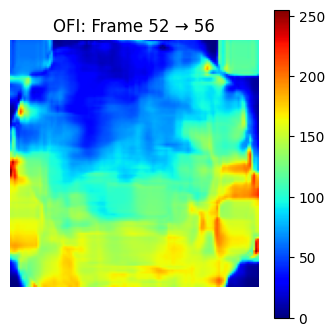

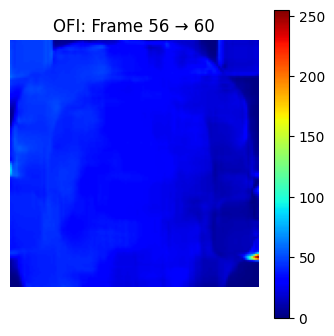

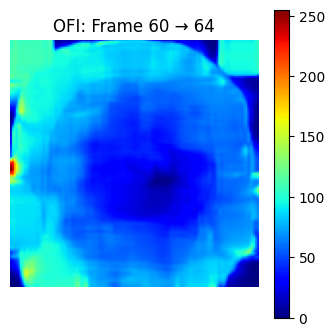

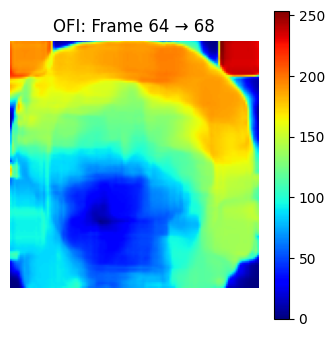

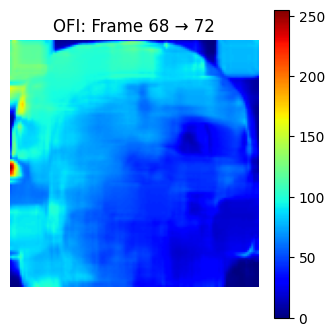

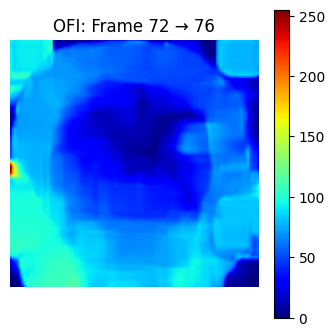

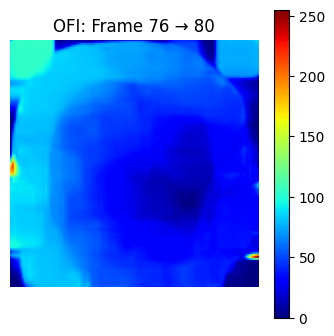

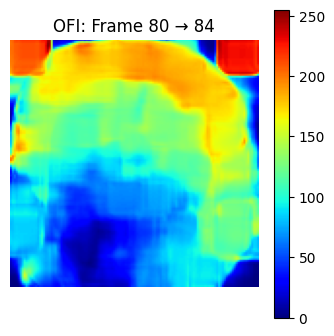

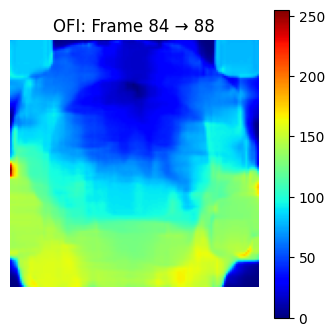

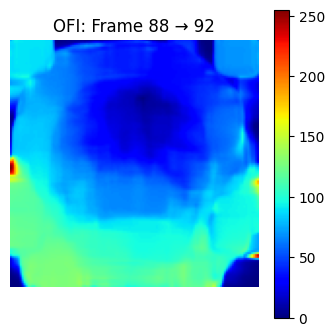

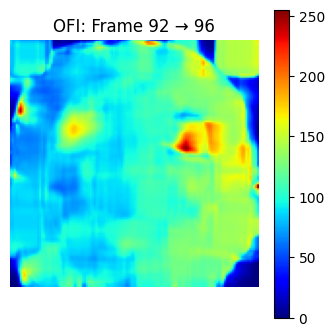

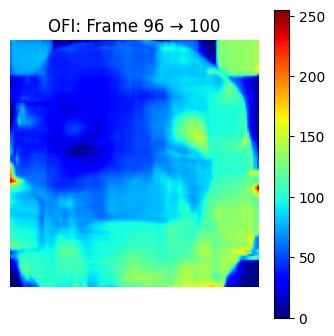

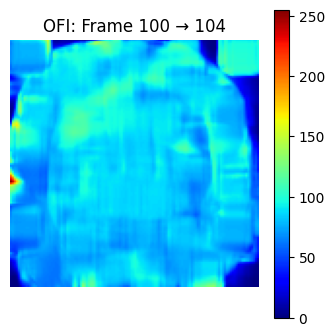

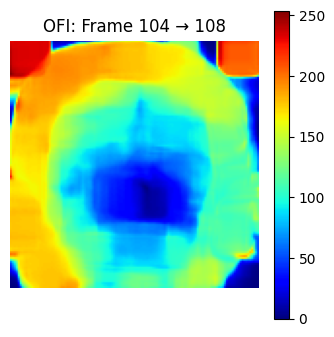

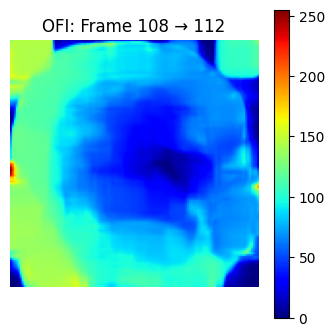

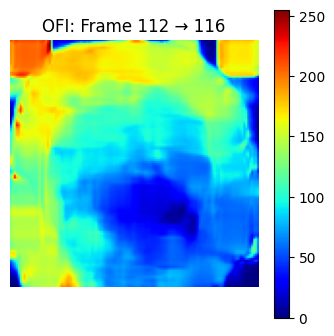

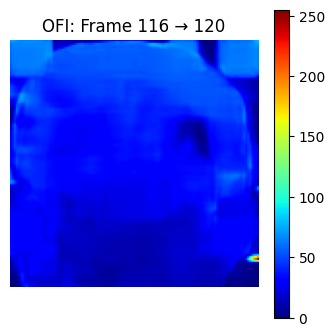

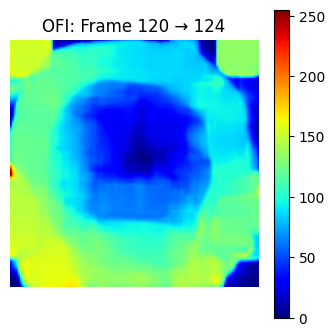

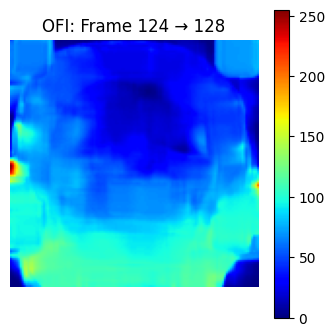

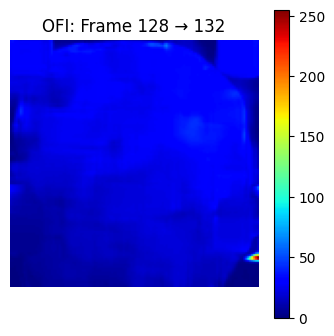

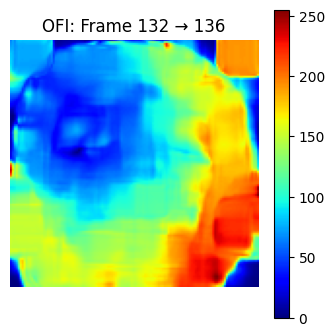

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Video path
video_path = ''

# Optical Flow Calculation Function
def compute_optical_flow(prev_gray, next_gray):
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

# Haar Cascade Face Detector (no dlib)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect face, crop, resize to 128x128
def detect_and_resize_face(gray_frame):
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face_crop = gray_frame[y:y+h, x:x+w]
        resized_face = cv2.resize(face_crop, (128, 128))
        return resized_face
    return None

# Extract aligned face frames from video
def process_video(video_path, frame_interval=4, max_frames=300):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return []

    frames = []
    for i in range(max_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)
        ret, frame = cap.read()
        if not ret:
            print(f"Error: Could not read frame {i * frame_interval}")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        aligned_face = detect_and_resize_face(gray)
        if aligned_face is not None:
            frames.append(aligned_face)
        else:
            print(f"Warning: No face detected in frame {i * frame_interval}")

    cap.release()
    return frames

# Compute OFI and show images in terminal one by one
def compute_ofi_and_show(frames, frame_interval=4):
    for i in range(1, len(frames)):
        prev_gray = frames[i-1]
        next_gray = frames[i]
        flow = compute_optical_flow(prev_gray, next_gray)

        # Compute magnitude and normalize
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        mag_normalized = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        mag_normalized = np.uint8(mag_normalized)

        # Display using matplotlib
        plt.figure(figsize=(4, 4))
        plt.imshow(mag_normalized, cmap='jet')
        plt.title(f'OFI: Frame {i*frame_interval - frame_interval} → {i*frame_interval}')
        plt.axis('off')
        plt.colorbar()
        plt.show()

# Main function
if __name__ == "__main__":
    frames = process_video(video_path, frame_interval=4, max_frames=300)

    if len(frames) > 1:
        compute_ofi_and_show(frames, frame_interval=4)
    else:
        print("Insufficient frames for optical flow computation.")


## Store the video path for no-pain (BL1) and pain (PA4) files

In [ ]:
import os

# Function to walk through the directory and find mp4 files containing "PA4"
# Same can be done for "BL1"

def find_bl1_mp4_files(directory):
    bl1_files = []

    # Walk through all files and subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is an mp4 and contains "PA4" in the name
            if file.endswith(".mp4") and "PA4" in file:
                # Get the full path of the file
                full_file_path = os.path.join(root, file)
                bl1_files.append(full_file_path)

    return bl1_files

# Example usage: Provide your directory path
directory_path = '' # Replace with your directory path

# Get list of mp4 files containing "PA4"
bl1_mp4_files = find_bl1_mp4_files(directory_path)

# Display the list
for file in bl1_mp4_files:
    print(file)


## Code to process video and same image files

In [ ]:
import cv2
import numpy as np
import os

# Function to compute optical flow using Farneback method
def compute_optical_flow(prev_gray, next_gray):
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

# Haar Cascade Face Detector (dlib removed)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to crop and resize face
def detect_and_resize_face(gray_frame):
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)
    if len(faces) > 0:
        x, y, w, h = faces[0]  # Use the first detected face
        face_crop = gray_frame[y:y+h, x:x+w]
        resized_face = cv2.resize(face_crop, (128, 128))
        return resized_face
    return None

# Function to process the video and extract aligned faces
def process_video(video_path, frame_interval=4, max_frames=100):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_to_process = min(total_frames // frame_interval, max_frames)

    frames = []

    for i in range(0, frames_to_process * frame_interval, frame_interval):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            aligned_face = detect_and_resize_face(gray)
            if aligned_face is not None:
                frames.append(aligned_face)
            else:
                print(f"Warning: No face detected in frame {i}")
        else:
            print(f"Error: Could not read frame {i}")
            break

    cap.release()
    cv2.destroyAllWindows()
    return frames

# Compute and save colorized OFI images
def compute_ofi_and_save(frames, video_name, video_output_dir, frame_interval=4):
    ofi_frames = []

    for i in range(1, len(frames)):
        ofi_image_name = f"{video_name}_OFI_{i * frame_interval - frame_interval}.png"
        ofi_image_path = os.path.join(video_output_dir, ofi_image_name)

        # Skip processing if image already exists
        if os.path.exists(ofi_image_path):
            print(f"Skipping existing image: {ofi_image_name}")
            continue

        prev_gray = frames[i-1]
        next_gray = frames[i]

        flow = compute_optical_flow(prev_gray, next_gray)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        mag = mag / (mag.max() + 1e-6)  # Avoid division by zero

        color_ofi = cv2.applyColorMap(np.uint8(mag * 255), cv2.COLORMAP_JET)

        cv2.imwrite(ofi_image_path, color_ofi)
        ofi_frames.append(color_ofi)

    return ofi_frames


# Process a single video file
def process_single_video(video_path, output_root_dir, frame_interval=4, max_frames=100):
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    video_output_dir = os.path.join(output_root_dir, video_name)
    os.makedirs(video_output_dir, exist_ok=True)

    print(f"Processing video: {video_name}")

    frames = process_video(video_path, frame_interval, max_frames)

    if len(frames) > 1:
        compute_ofi_and_save(frames, video_name, video_output_dir, frame_interval)
    else:
        print(f"Skipping {video_name} due to insufficient frames.")

# Example Usage
output_root_dir = ''

for video_path in bl1_mp4_files:
    process_single_video(video_path, output_root_dir)


Processing video: 071814_w_23-PA4-006
Processing video: 071814_w_23-PA4-007
Processing video: 071814_w_23-PA4-008
Processing video: 071814_w_23-PA4-015
Processing video: 071814_w_23-PA4-022
Processing video: 071814_w_23-PA4-023
Processing video: 071814_w_23-PA4-032
Processing video: 071814_w_23-PA4-034
Processing video: 071814_w_23-PA4-038
Processing video: 071814_w_23-PA4-042
Processing video: 071814_w_23-PA4-043
Processing video: 071814_w_23-PA4-051
Processing video: 071814_w_23-PA4-052
Processing video: 071814_w_23-PA4-053
Processing video: 071814_w_23-PA4-054
Processing video: 071814_w_23-PA4-056
Processing video: 071814_w_23-PA4-066
Processing video: 071814_w_23-PA4-070
Processing video: 071814_w_23-PA4-076
Processing video: 071814_w_23-PA4-079
Processing video: 071911_w_24-PA4-008
Processing video: 071911_w_24-PA4-011
Processing video: 071911_w_24-PA4-014
Processing video: 071911_w_24-PA4-018
Processing video: 071911_w_24-PA4-025
Processing video: 071911_w_24-PA4-028
Processing v